In [1]:
import os
os.chdir('modules')
from train import train, score
from get_data import get_data
from model import LangID, LogisticRegression, ComplementNB, BernoulliNB
from get_gpt_reviews import get_gpt_reviews
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
Xt, Yt = get_data("dev", cleanText=True)

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
from get_data import get_data
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange, tqdm
from model import OnehotTransformer,LogisticRegressionPytorch
import torch

Device used = cuda


Augmented 'x' size of original: 1099.4 for size 10
Fitted vocab size: 180
Fitted vocab size: 960
Fitted vocab size: 1261
Fitted vocab size: 1484
Fitted vocab size: 1645
Fitted vocab size: 1801
Fitted vocab size: 1922
Fitted vocab size: 2045
Fitted vocab size: 2164
Fitted vocab size: 2272
Fitted vocab size: 1441


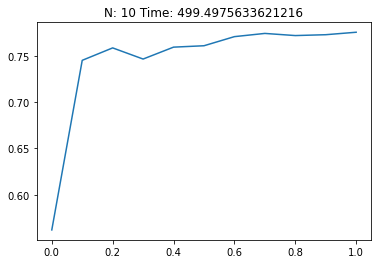

Augmented 'x' size of original: 999.0 for size 50
Fitted vocab size: 940
Fitted vocab size: 3471
Fitted vocab size: 2650
Fitted vocab size: 3088
Fitted vocab size: 2772
Fitted vocab size: 3020
Fitted vocab size: 2833
Fitted vocab size: 3036
Fitted vocab size: 2869
Fitted vocab size: 3003
Fitted vocab size: 3157


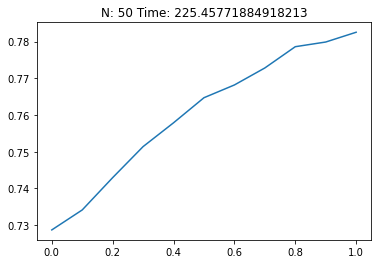

Augmented 'x' size of original: 182.52 for size 100
Fitted vocab size: 1288
Fitted vocab size: 2575
Fitted vocab size: 3215
Fitted vocab size: 3671
Fitted vocab size: 4039
Fitted vocab size: 4361
Fitted vocab size: 2912
Fitted vocab size: 3086
Fitted vocab size: 3224
Fitted vocab size: 3377
Fitted vocab size: 3518


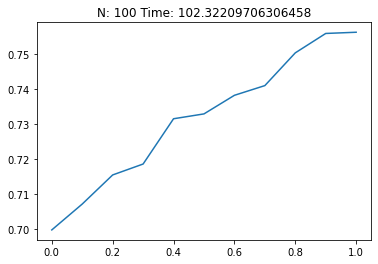

Augmented 'x' size of original: 99.0 for size 500
Fitted vocab size: 3709
Fitted vocab size: 5100
Fitted vocab size: 3847
Fitted vocab size: 4252
Fitted vocab size: 3910
Fitted vocab size: 4147
Fitted vocab size: 3897
Fitted vocab size: 4062
Fitted vocab size: 3882
Fitted vocab size: 4006
Fitted vocab size: 4134


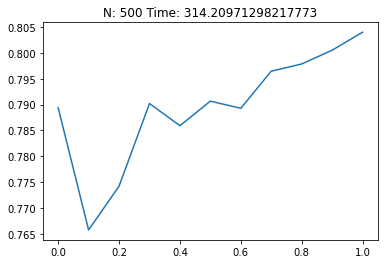

Augmented 'x' size of original: 5.229 for size 2000
Fitted vocab size: 8963
Fitted vocab size: 9106
Fitted vocab size: 9245
Fitted vocab size: 9356
Fitted vocab size: 9462
Fitted vocab size: 9579
Fitted vocab size: 9707
Fitted vocab size: 9801
Fitted vocab size: 6461
Fitted vocab size: 6655
Fitted vocab size: 6785


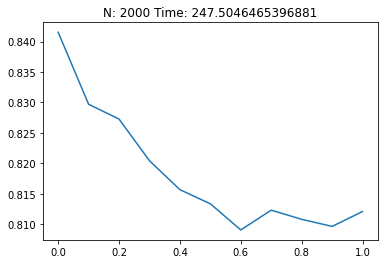

In [18]:
## SKLEARN

clean = 'clean_' # Type either '' or 'clean_'
method = "gpt"
ns = [10, 50, 100, 500, 2000]


for n in ns:
    data_type = clean + method + f"_{n}"
    X_all, Y_all = get_data(data_type)
    X_all, Y_all = X_all[-50_000:], Y_all[-50_000:]
    aug_len = len(X_all) - n
    print("Augmented 'x' size of original:", aug_len/n, "for size", n)
    start = time()
    ps, scores = [], []
    for i in range(0, 101, 10):
        p = i/100
        data_size = int(n + p*aug_len) # exclusive to avoid indexing [-1:]
        X, Y = X_all[-data_size:], Y_all[-data_size:]
        model = LogisticRegression(max_iter=100, ngram_range=(1, 1), min_df=0.0001, max_df=.5, verbose_vocab=True)
        model.fit(X, Y)
        acc = (model.predict(Xt) == np.array(Yt)).mean()
        scores.append(acc)
        ps.append(p)
    plt.plot(ps, scores)
    plt.title('N: ' + str(n) + ' Time: ' + str(time() - start))
    plt.show()

Augmented 'x' size of original: 1099.4 for size 10
Fitted vocab size: 180
Fitted vocab size: 518
Fitted vocab size: 520
Fitted vocab size: 535
Fitted vocab size: 543
Fitted vocab size: 549
Fitted vocab size: 554
Fitted vocab size: 555
Fitted vocab size: 566
Fitted vocab size: 561
Fitted vocab size: 544


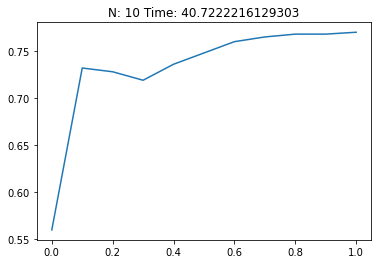

Augmented 'x' size of original: 3827.04 for size 50
Fitted vocab size: 940
Fitted vocab size: 1209
Fitted vocab size: 1219
Fitted vocab size: 1218
Fitted vocab size: 1221
Fitted vocab size: 1220
Fitted vocab size: 1218
Fitted vocab size: 1217
Fitted vocab size: 1218
Fitted vocab size: 1220
Fitted vocab size: 1214


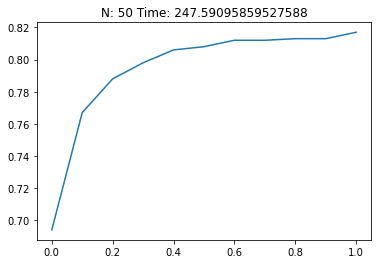

Augmented 'x' size of original: 182.52 for size 100
Fitted vocab size: 1288
Fitted vocab size: 1564
Fitted vocab size: 1400
Fitted vocab size: 1378
Fitted vocab size: 1370
Fitted vocab size: 1364
Fitted vocab size: 1362
Fitted vocab size: 1390
Fitted vocab size: 1376
Fitted vocab size: 1376
Fitted vocab size: 1369


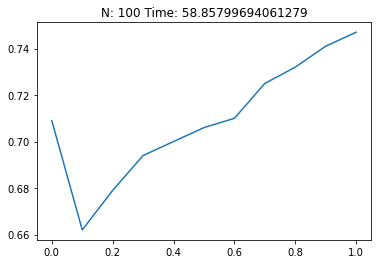

Augmented 'x' size of original: 198.128 for size 500
Fitted vocab size: 3709
Fitted vocab size: 1523
Fitted vocab size: 1421
Fitted vocab size: 1389
Fitted vocab size: 1382
Fitted vocab size: 1387
Fitted vocab size: 1404
Fitted vocab size: 1398
Fitted vocab size: 1398
Fitted vocab size: 1381
Fitted vocab size: 1381


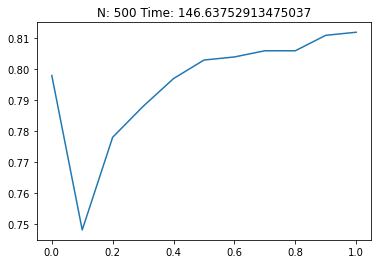

Augmented 'x' size of original: 5.229 for size 2000
Fitted vocab size: 3885
Fitted vocab size: 2314
Fitted vocab size: 2152
Fitted vocab size: 1997
Fitted vocab size: 1913
Fitted vocab size: 1841
Fitted vocab size: 1802
Fitted vocab size: 1777
Fitted vocab size: 1743
Fitted vocab size: 1716
Fitted vocab size: 1697


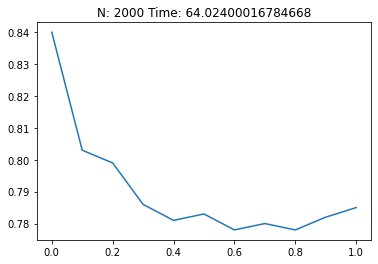

In [2]:
## PYTORCH
from time import time

clean = 'clean_' # Type either '' or 'clean_'
method = "gpt"
ns = [10, 50, 100, 500, 2000]

for n in ns:
    data_type = clean + method + f"_{n}"
    X_all, Y_all = get_data(data_type)
    aug_len = len(X_all) - n
    print("Augmented 'x' size of original:", aug_len/n, "for size", n)

    start = time()
    ps, scores = [], []
    for i in range(0, 101, 10):
        p = i/100
        data_size = int(n + p*aug_len) # exclusive to avoid indexing [-1:]
        X, Y = X_all[-data_size:], Y_all[-data_size:]

        transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.001, max_df=0.5, verbose_vocab=True)
        transformer.fit(X,Y)
        X = transformer.transform(X)

        model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
        batch_size = min(int(data_size*0.1)-1, 4096)
        if batch_size < 10:
            batch_size = 10
        model.train(X, Y, batch_size=batch_size)

        acc = model.score(transformer.transform(Xt),Yt)

        scores.append(acc)
        ps.append(p)
    plt.plot(ps, scores)
    plt.title('N: ' + str(n) + ' Time: ' + str(time() - start))
    plt.show()

In [5]:
n = 10
X_all, Y_all = get_data("gpt_" + str(n))
ps, scores = [], []
model = LogisticRegression(max_iter=100)
model.fit(X_all, Y_all)
probs = model.predict_proba(X_all)

# Assume the following:
# p = 0.1 (of being positive)
# l = 1 (positive)

# p - l -> abs(0.01 - 1) > 0.99 
# Will catch wrong predictions
poor_idxs = sorted([((p - l), i) for p, l, i in zip(probs[:,1], Y_all, range(len(probs))) if abs(p - l) > 0.5], reverse=True)

for p, i in poor_idxs[:5] + poor_idxs[-5:]:
    print(p, X_all[i], Y_all[i])

[(0.9786618767028333, 7410), (0.9738154995645933, 5167), (0.9594496207026467, 10134), (0.9534950052842786, 3768), (0.953447303427169, 10434)] [(-0.9761634601811011, 2204), (-0.9778834092588022, 5165), (-0.9783390951082487, 5169), (-0.9887748260378542, 1231), (-0.9920405854363001, 2397)]
0.9786618767028333 great songs. excellent album. it is so nice to hear a singer in english. 0
0.9738154995645933 this album has been stuck in my head for days. i think the album is really cool. 0
0.9594496207026467 i really love his voice. to bad he gave up. 0
0.9534950052842786 i love it. great rock music. very good band. 0
0.953447303427169 this album has been stuck in my head for days. the songwriting is the best thing about this album. 0
-0.9761634601811011 this album is a formulaic rip-offs with no passion. the entire thing is trash. 1
-0.9778834092588022 i bought two albums from the "greatest hits" series, but this album is the worst of the bunch 1
-0.9783390951082487 the album is very boring and 

In [2]:
## PYTORCH - QUALITY CHECK - EXCLUDING 2000
from time import time

clean = 'clean_' # Type either '' or 'clean_'
method = "gpt"
ns = [50, 100, 500]#, 2000]

for n in ns:
    print('\nDoing size', n)
    data_type = clean + method + f"_{n}"
    X_all, Y_all = get_data(data_type)
    X_all, Y_all = X_all[:-100_000], Y_all[:-100_000]

    transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.001, max_df=0.5, verbose_vocab=True)
    transformer.fit(X_all,Y_all)
    X = transformer.transform(X_all)
    print("model 1")
    model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
    batch_size = min(int(len(X_all)*0.1)-1, 1024)
    if batch_size < 10:
        batch_size = 10
    Y = Y_all.copy()
    model.train(X, Y, batch_size=batch_size)
    probs = model.predict_proba(X)
    poor_idxs = sorted([((p - l), i) for p, l, i in zip(probs[:,1], Y_all, range(len(probs))) if abs(p - l) > 0.5], reverse=True)
    del model, probs, transformer, X, Y

    start = time()
    ps, scores = [], []
    for del_p in range(0, 101, 10):
        half_del_size = max(1, int((del_p / 100)*len(poor_idxs))//2)
        del_idxs = set(i for (p, i) in poor_idxs[:half_del_size] + poor_idxs[-half_del_size:])
        print('Deleting', len(del_idxs), 'constituting', len(del_idxs)/len(X_all), 'percent')
        X = [x for i, x in enumerate(X_all) if i not in del_idxs]
        Y = [y for i, y in enumerate(Y_all) if i not in del_idxs]
        transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.001, max_df=0.5, verbose_vocab=True)
        transformer.fit(X,Y)
        X = transformer.transform(X)
        print("model 2")
        model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
        batch_size = min(int(len(X)*0.1)-1, 1024)
        if batch_size < 10:
            batch_size = 10
        print("model 3")
        import gc

        gc.collect()

        torch.cuda.empty_cache()
        
        model.train(X, Y, batch_size=batch_size)
        del X, Y
        with torch.no_grad():
            acc = model.score(transformer.transform(Xt), Yt.copy())
            scores.append(acc)
            ps.append(del_p/100)
        del model, transformer, acc
    plt.plot(ps, scores)
    plt.title('Size: ' + str(n) + ' Time: ' + str(time() - start))
    plt.show()


Doing size 50
Fitted vocab size: 1214
model 1
Deleting 2 constituting 1.0449211606984254e-05 percent
Fitted vocab size: 1213
model 2
model 3


RuntimeError: CUDA out of memory. Tried to allocate 1.73 GiB (GPU 0; 4.00 GiB total capacity; 911.77 MiB already allocated; 1.13 GiB free; 1.76 GiB reserved in total by PyTorch)

In [20]:
X, Y = get_data("clean_gpt_100")
transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.001, max_df=0.5, verbose_vocab=True)
transformer.fit(X,Y)
X = transformer.transform(X)

model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
batch_size = min(int(len(X)*0.1)-1, 4096)
if batch_size < 10:
    batch_size = 10
model.train(X, Y, batch_size=batch_size)
probs = model.predict_proba(X)
poor_idxs = sorted([((p - l).item(), i) for p, l, i in zip(probs[:,1], Y, range(len(probs))) if abs(p - l) > 0.5], reverse=True)


Fitted vocab size: 1369


In [21]:
model.score(transformer.transform(Xt), Yt)

0.747

In [2]:
for del_p in range(0, 26, 5):
    del_size = int((del_p / 100)*len(poor_idxs))//2
    del_idxs = set(poor_idxs[:del_size] + poor_idxs[-del_size:])
    print('Deleting', len(del_idxs), 'constituting', len(del_idxs)/len(X_all), 'percent')
    
    X = [x for i, x in enumerate(X_all) if i not in del_idxs]
    Y = [y for i, y in enumerate(Y_all) if i not in del_idxs]
    
    new_len = len(X) - n
    ps, scores = [], []
    for i in range(0, 101, 20):
        p = i/100
        data_size = int(size + p*new_len) # exclusive to avoid indexing [-1:]
        x, y = X[-data_size:], Y[-data_size:]
        
        transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.001, max_df=0.5, verbose_vocab=True)
        transformer.fit(X,Y)
        X = transformer.transform(X)

        model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
        batch_size = min(int(data_size*0.1)-1, 4096)
        if batch_size < 10:
            batch_size = 10
        model.train(X, Y, batch_size=batch_size)

        acc = model.score(transformer.transform(Xt),Yt)
        scores.append(acc)
        ps.append(p)
    plt.plot(ps, scores)
    plt.title('Percentage of poor labels deleted: ' + str(del_p))
    plt.show()

NameError: name 'poor_idxs' is not defined

In [ ]:
# Comparing performance of cleaning data

min_df = 0.0001
max_df = .5
n_gram_range = (1, 1)
for n in [10, 50, 100, 500, 2000]:
    Xt, Yt = get_data("dev")
    X, Y = get_data("gpt_" + str(n), early_return=False)
    X, Y = X[-5000:], Y[-5000:]
    model = LogisticRegression(max_iter=100, ngram_range=n_gram_range, min_df=min_df, max_df=max_df, verbose_vocab=True)
    model.fit(X, Y)
    print((model.predict(Xt) == np.array(Yt)).mean())

    Xt, Yt = get_data("dev", cleanText=True)
    X, Y = get_data("gpt_" + str(n), early_return=False, cleanText=True)
    X, Y = X[-5000:], Y[-5000:]
    model = LogisticRegression(max_iter=100, ngram_range=n_gram_range, min_df=min_df, max_df=max_df, verbose_vocab=True)
    model.fit(X, Y)
    print((model.predict(Xt) == np.array(Yt)).mean())
    
    print('\n')
